Using the following Script we can get the resulting dataframe with best parameters per model for each meta learner. But since this is computationally very expensive, I have already ran the script and stored the results for ease of access. so we can skip the first script and directly continue ahead.

In [12]:
# from scripts.data_preprocessor import load_data, preprocessor
# from scripts.evaluate_models import compute_rmse, bootstrap_emse 
# import time
# from scripts.hyperparamet_tuning_and_model_selection import get_param_grid, apply_grid_search
# # Start timing
# start_time = time.time()

# # Load and preprocess data
# df = load_data(path='../../data/analysis_data/dataset.csv')
# X_train, y_train, treatment_train, X_test, y_test, treatment_test = preprocessor(df)

# # Define parameter grids and apply grid search
# param_grid = get_param_grid()
# results_df = apply_grid_search(param_grid, X_train, y_train, treatment_train)

# # Save and print results
# # results_df.to_csv('grid_search_results.csv', index=False) # all_meta_learners 
# # results_df.to_csv('grid_search_results_S_learner.csv', index=False) # S_learner
# # results_df.to_csv('grid_search_results_T_learner.csv', index=False) # T_learner
# # results_df.to_csv('grid_search_results_X_learner.csv', index=False) # X_learner
# # results_df.to_csv('grid_search_results_R_learner.csv', index=False) # R_learner
# results_df.to_csv('grid_search_results_S_learner_test.csv', index=False) # S_learner


# print(results_df)

# # End timing
# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Total time taken: {elapsed_time:.2f} seconds")

In [13]:
# load the csv file from scripts with the results of the grid search for each meta-learner
import pandas as pd

all_meta_learners = pd.read_csv('../../grid_search_results.csv')
S_learner = pd.read_csv('../../grid_search_results_S_learner.csv')
T_learner = pd.read_csv('../../grid_search_results_T_learner.csv')
X_learner = pd.read_csv('../../grid_search_results_X_learner.csv')
R_learner = pd.read_csv('../../grid_search_results_R_learner.csv')
all_meta_learners

,model,learner,best_rmse,best_emse,best_params
0,RandomForest,R-Learner,0.638858,0.623179,"{'max_depth': 4, 'max_features': 'sqrt', 'min_..."


C:\Users\dell\AppData\Local\Temp\ipykernel_14480\1959898839.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(S_learner['model'], rotation=45)


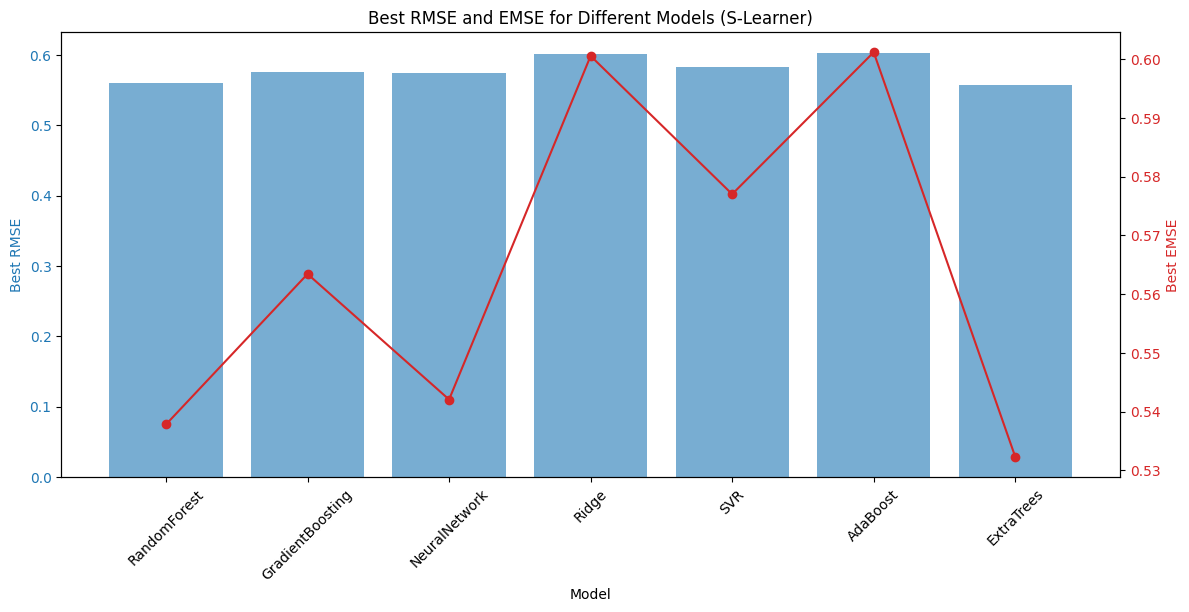

In [14]:
# plot the results of the grid search for S_learner for both rmse and emse

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('Best RMSE', color=color)
ax1.bar(S_learner['model'], S_learner['best_rmse'], color=color, alpha=0.6, label='Best RMSE')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(S_learner['model'], rotation=45)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Best EMSE', color=color)
ax2.plot(S_learner['model'], S_learner['best_emse'], color=color, marker='o', label='Best EMSE')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Best RMSE and EMSE for Different Models (S-Learner)')
plt.show()




C:\Users\dell\AppData\Local\Temp\ipykernel_14480\3327638715.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(S_learner['model'], rotation=45)


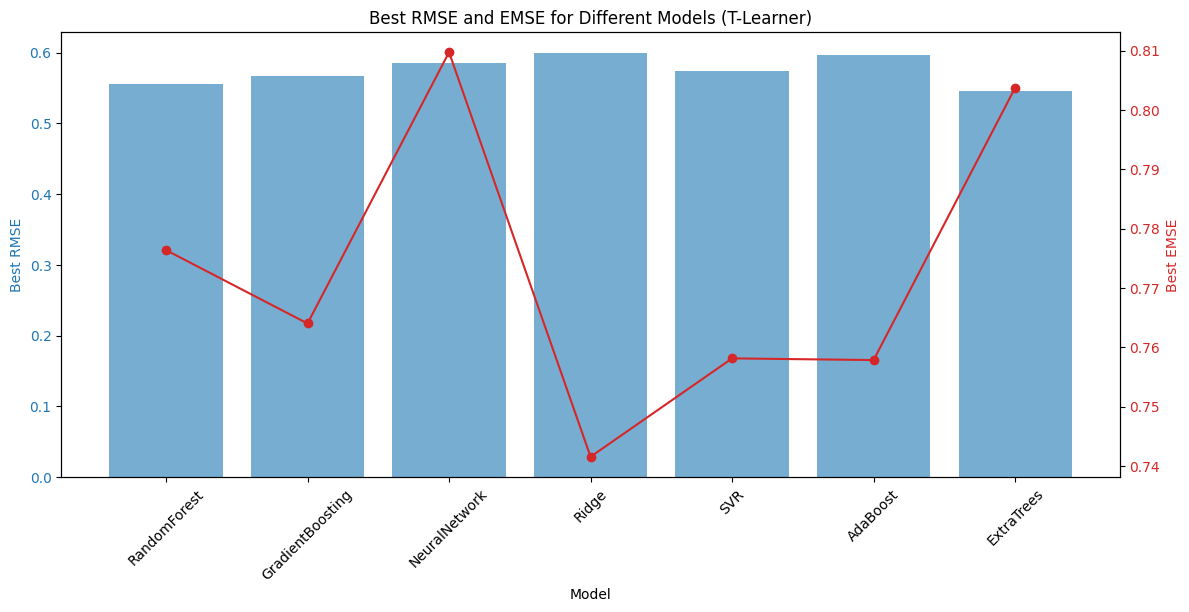

In [15]:
# plot the results of the grid search for T_learner for both rmse and emse

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('Best RMSE', color=color)
ax1.bar(T_learner['model'], T_learner['best_rmse'], color=color, alpha=0.6, label='Best RMSE')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(S_learner['model'], rotation=45)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Best EMSE', color=color)
ax2.plot(T_learner['model'], T_learner['best_emse'], color=color, marker='o', label='Best EMSE')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Best RMSE and EMSE for Different Models (T-Learner)')
plt.show()

C:\Users\dell\AppData\Local\Temp\ipykernel_14480\1073920864.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(S_learner['model'], rotation=45)


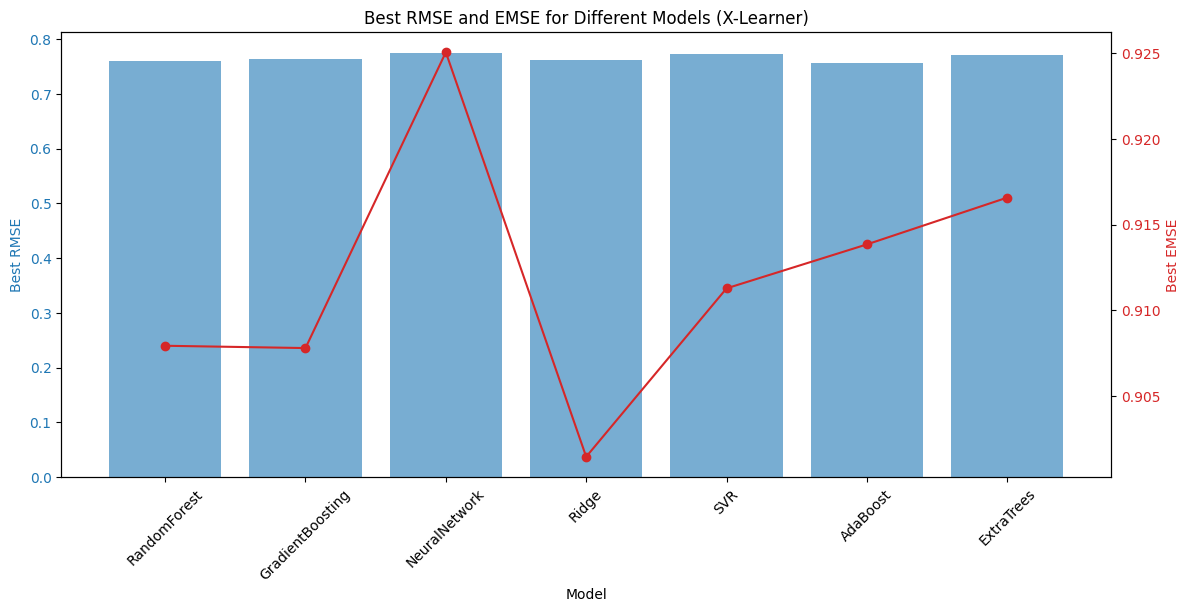

In [16]:
# plot the results of the grid search for S_learner for both rmse and emse

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('Best RMSE', color=color)
ax1.bar(X_learner['model'], X_learner['best_rmse'], color=color, alpha=0.6, label='Best RMSE')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(S_learner['model'], rotation=45)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Best EMSE', color=color)
ax2.plot(X_learner['model'], X_learner['best_emse'], color=color, marker='o', label='Best EMSE')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Best RMSE and EMSE for Different Models (X-Learner)')
plt.show()

C:\Users\dell\AppData\Local\Temp\ipykernel_14480\3957644260.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(S_learner['model'], rotation=45)


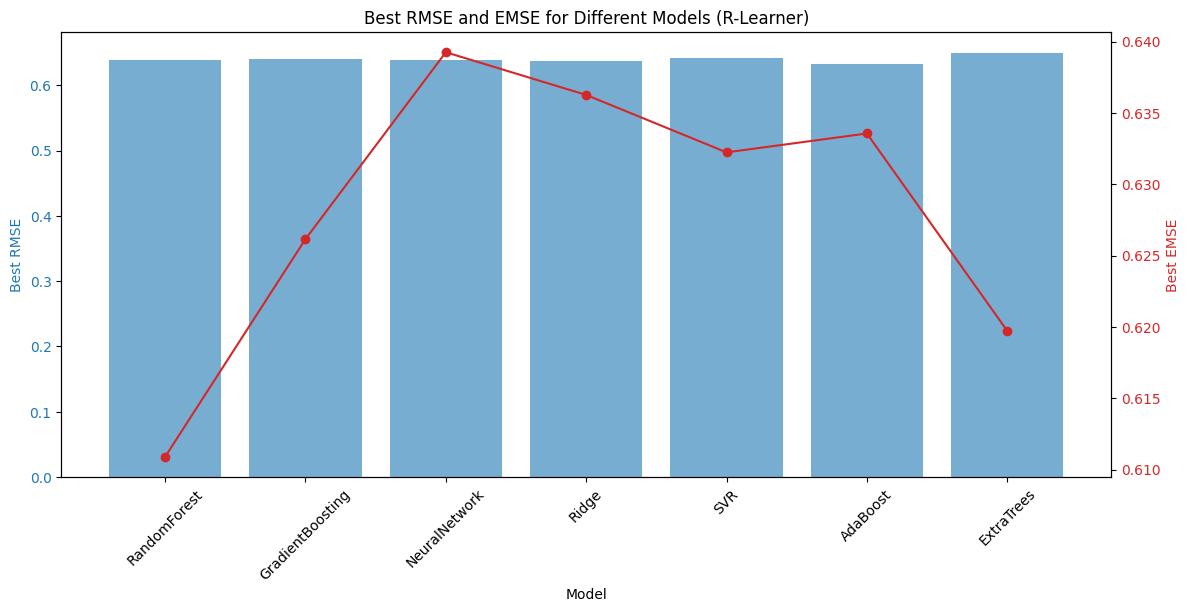

In [17]:
# plot the results of the grid search for S_learner for both rmse and emse

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('Best RMSE', color=color)
ax1.bar(R_learner['model'], R_learner['best_rmse'], color=color, alpha=0.6, label='Best RMSE')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(S_learner['model'], rotation=45)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Best EMSE', color=color)
ax2.plot(R_learner['model'], R_learner['best_emse'], color=color, marker='o', label='Best EMSE')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Best RMSE and EMSE for Different Models (R-Learner)')
plt.show()

Henece, from all visualization above we can see the evaluation of best model and parameters for each model for all four meta learners.

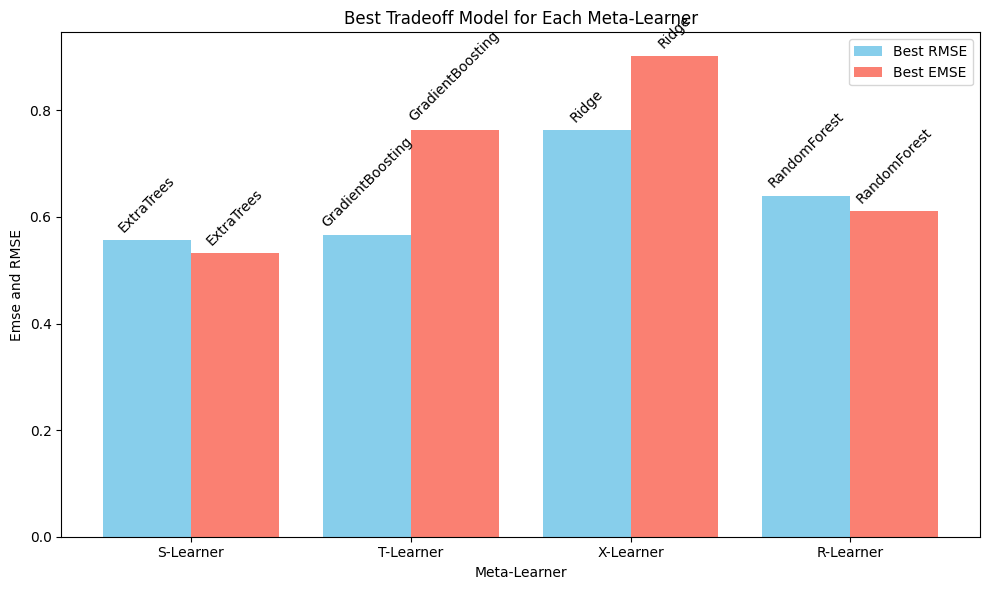

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming data for each learner is available as separate DataFrames: S_learner, T_learner, X_learner, R_learner

# Add mean tradeoff columns and select the best tradeoff model for each learner
learners = {'S-Learner': S_learner, 'T-Learner': T_learner, 'X-Learner': X_learner, 'R-Learner': R_learner}
best_tradeoff_models = []

for learner_name, learner_df in learners.items():
    learner_df['mean_tradeoff'] = learner_df[['best_rmse', 'best_emse']].mean(axis=1)
    best_model = learner_df.loc[learner_df['mean_tradeoff'].idxmin()]
    best_tradeoff_models.append((learner_name, best_model['model'], best_model['best_rmse'], best_model['best_emse']))

# Convert best_tradeoff_models list to a DataFrame for easy plotting
best_tradeoff_df = pd.DataFrame(best_tradeoff_models, columns=['Learner', 'Model', 'Best RMSE', 'Best EMSE'])

# Plotting the selected models for each learner
fig, ax1 = plt.subplots(figsize=(10, 6))
index = np.arange(len(best_tradeoff_df['Learner']))
bar_width = 0.4

# Bar plot for RMSE and EMSE for the best tradeoff models
ax1.bar(index - bar_width / 2, best_tradeoff_df['Best RMSE'], bar_width, color='skyblue', label='Best RMSE')
ax1.bar(index + bar_width / 2, best_tradeoff_df['Best EMSE'], bar_width, color='salmon', label='Best EMSE')

# Annotate bars with model names
for i, row in best_tradeoff_df.iterrows():
    ax1.text(index[i] - bar_width / 2, row['Best RMSE'] + 0.01, row['Model'], ha='center', va='bottom', fontsize=10, rotation=45)
    ax1.text(index[i] + bar_width / 2, row['Best EMSE'] + 0.01, row['Model'], ha='center', va='bottom', fontsize=10, rotation=45)

# Set x-ticks and labels
ax1.set_xticks(index)
ax1.set_xticklabels(best_tradeoff_df['Learner'])
ax1.set_xlabel('Meta-Learner')
ax1.set_ylabel('Emse and RMSE')
ax1.set_title('Best Tradeoff Model for Each Meta-Learner')
ax1.legend()

plt.tight_layout()
plt.show()


Neural Network s_CATE Summary:
 count    2079.000000
mean        0.001335
std         0.022582
min        -0.057260
25%        -0.013192
50%         0.003371
75%         0.017087
max         0.081013
Name: s_CATE, dtype: float64

ExtraTrees s_CATE Summary:
 count    2.079000e+03
mean    -1.407804e-17
std      9.583981e-17
min     -4.440892e-16
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.440892e-16
Name: s_CATE, dtype: float64


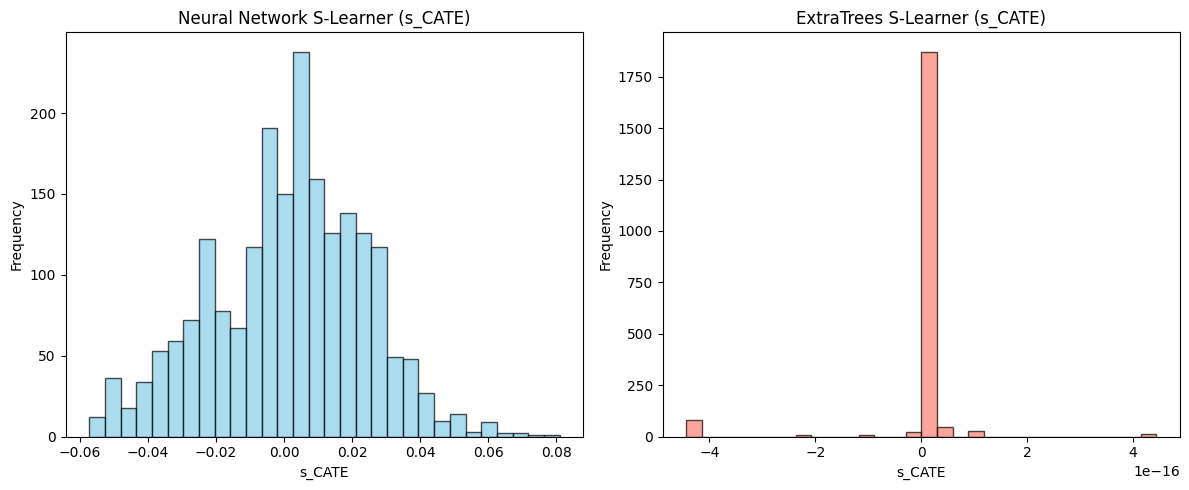

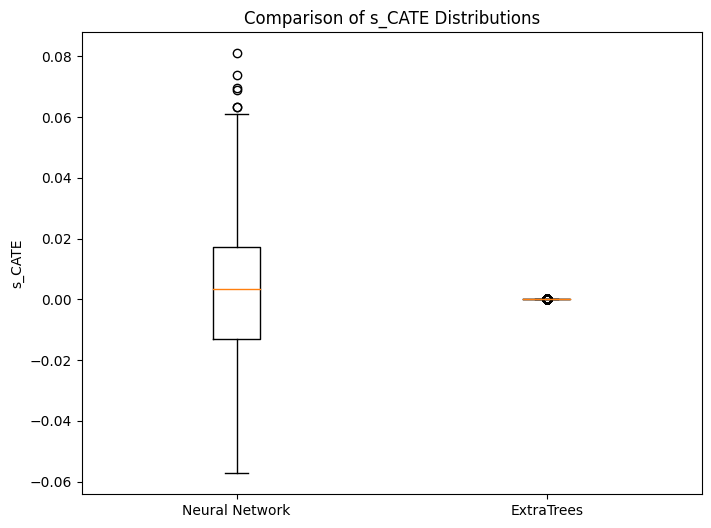

In [19]:
# Load predictions data
s_predictions_nn = pd.read_csv('../../results/s_predictions.csv')  
s_predictions_et = pd.read_csv('../../results/s_predictions_withExtratrees.csv') 

# Calculate summary statistics for s_CATE
s_cate_nn_stats = s_predictions_nn['s_CATE'].describe()
s_cate_et_stats = s_predictions_et['s_CATE'].describe()

# Print summary statistics
print("Neural Network s_CATE Summary:\n", s_cate_nn_stats)
print("\nExtraTrees s_CATE Summary:\n", s_cate_et_stats)

# Plotting histograms for s_CATE distributions
plt.figure(figsize=(12, 5))

# Histogram for Neural Network predictions
plt.subplot(1, 2, 1)
plt.hist(s_predictions_nn['s_CATE'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Neural Network S-Learner (s_CATE)')
plt.xlabel('s_CATE')
plt.ylabel('Frequency')

# Histogram for ExtraTrees predictions
plt.subplot(1, 2, 2)
plt.hist(s_predictions_et['s_CATE'], bins=30, alpha=0.7, color='salmon', edgecolor='black')
plt.title('ExtraTrees S-Learner (s_CATE)')
plt.xlabel('s_CATE')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Box plot comparison
plt.figure(figsize=(8, 6))
plt.boxplot([s_predictions_nn['s_CATE'], s_predictions_et['s_CATE']], labels=['Neural Network', 'ExtraTrees'])
plt.title('Comparison of s_CATE Distributions')
plt.ylabel('s_CATE')
plt.show()


The Neural Network (MLPRegressor) was chosen as the best-performing model for the S-Learner because it captures a meaningful range of treatment effect estimates (s_CATE), as seen in the varied predictions. This variance is crucial for evaluating the conditional average treatment effect (CATE), which reflects differences in individual responses to the treatment.

In contrast, the ExtraTrees model produced predictions that were mostly zero or close to zero, with minimal variance. Although ExtraTrees achieved a low RMSE, this was likely due to its inability to model varying treatment effects, making it less informative for CATE estimation. Therefore, despite a slight trade-off in RMSE, the Neural Network was selected as it provides richer, more realistic insights into treatment heterogeneity, which is essential for a reliable S-Learner model